In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
from mne_connectivity import spectral_connectivity_epochs,phase_slope_index,seed_target_indices,check_indices

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [7]:
#one subject 
anat_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/MS017_labels.csv'
data_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS017/'

subj_id = 'MS017'
freqs = np.logspace(*np.log10([4, 120]), num=20)


In [71]:
epochs_data = mne.read_epochs(f'{data_path}epoch_DecisionOnset.fif')
#epochs_data_decision = mne.read_epochs(f'{data_path}epoch_DecisionOnset.fif')


elec_data = lfp_preprocess_utils.load_elec(anat_path)


anode_list = [x.split('-')[0] for x in epochs_data.ch_names]
elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
elec_df['label'] = epochs_data.ch_names



/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_3047/816277711.py:1: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS017/epoch_DecisionOnset.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_data = mne.read_epochs(f'{data_path}epoch_DecisionOnset.fif')
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_3047/816277711.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_data.ch_names


In [9]:
epochs_data.ch_names

['lacas1-lalps4',
 'lacas10-lalps9',
 'lacas2-lalps4',
 'lacas3-lalps4',
 'lacas4-lmolf1',
 'lacas5-lmolf5',
 'lacas6-lalps4',
 'lacas7-lmcms6',
 'lacas8-lalps7',
 'laglt1-ltplt4',
 'laglt2-lhplt5',
 'laglt3-lhplt5',
 'laglt4-lhplt5',
 'laglt5-lhplt5',
 'laglt6-lhplt6',
 'laglt7-lhplt7',
 'laglt8-lhplt7',
 'laglt9-lhplt7',
 'lalps1-lalps6',
 'lalps11-lalps9',
 'lalps12-lalps9',
 'lalps13-lmcms6',
 'lalps2-lalps6',
 'lalps3-lalps6',
 'lhplt1-lhplt5',
 'lhplt10-lllt4',
 'lhplt2-lhplt5',
 'lhplt3-lhplt5',
 'lhplt4-lhplt5',
 'lhplt8-lhplt7',
 'lhplt9-lllt5',
 'lllt1-lhplt5',
 'lllt2-lllt4',
 'lllt3-lhplt6',
 'lllt6-lhplt7',
 'lllt7-lhplt7',
 'lmcms1-lalps8',
 'lmcms2-lalps8',
 'lmcms3-lalps9',
 'lmcms4-lalps9',
 'lmcms7-lalps10',
 'lmcms8-lalps10',
 'lmlbr1-lalps6',
 'lmlbr2-lllt4',
 'lmlbr3-lhplt7',
 'lmlbr4-lhplt7',
 'lmolf2-lalps4',
 'lmolf4-lalps4',
 'lmolf6-lalps4',
 'lmolf7-lalps4',
 'lmolf8-lalps4',
 'lmolf9-lalps5',
 'lpcwr10-lplsp6',
 'lpcwr11-lplsp6',
 'lpcwr12-lplsp7',
 'lpcwr7-

In [516]:
elec_df

label BN246label          x          y          z      mni_x  \
0      lacas1-lmoif6    A32sg_L  -6.784557  49.555827   0.149337  -6.382462   
1    lacas10-laims14      A9l_L  -8.380923  61.155821  43.676991  -8.220073   
4      lacas2-lmoif3    A32sg_L  -6.784557  50.755827   4.941372  -6.368174   
5      lacas3-lmoif7    A32sg_L  -6.784557  51.955826   9.733407  -6.390079   
6      lacas4-lmoif5     A32p_L  -7.183649  53.555825  14.525443  -6.914519   
..               ...        ...        ...        ...        ...        ...   
151    rmoif3-raims7     A11l_R  25.940934  43.955830 -14.226769  26.587567   
154    rmoif6-raims7  A12/47l_R  37.913675  41.555831  -6.240044  38.716568   
155    rmoif7-raims7  A12/47l_R  41.904589  40.755832  -3.844026  42.794042   
156    rmoif8-raims7  A12/47l_R  46.294594  39.555832  -1.048672  47.308597   
157    rmoif9-raims7     A45r_R  50.285508  38.755833   1.746682  51.450368   

         mni_y      mni_z    gm  \
0    37.158688  -3.130044  Gray   
1    48.757099  44.868611  Gray   
4    38.606223   2.270621  Gray   
5    39.941566   7.640265  Gray   
6    41.546899  12.993427  Gray   
..         ...        ...   ...   
151  30.321151 -19.158925  Gray   
154  28.139395 -11.063832  Gray   
155  27.279509  -8.584441  Gray   
156  25.926043  -5.816665  Gray   
157  25.170889  -3.096492  Gray   

                                                   NMM      Anat  \
0                   Left ACgG anterior cingulate gyrus   Unknown   
1                      Left SFG superior frontal gyrus   Unknown   
4                   Left ACgG anterior cingulate gyrus   Unknown   
5                   Left ACgG anterior cingulate gyrus   Unknown   
6                   Left ACgG anterior cingulate gyrus   Unknown   
..                                                 ...       ...   
151                 Right POrG posterior orbital gyrus  Area Fo3   
154                        Right Cerebral White Matter   Unknown   
155  Right OrIFG orbital part of the inferior front...   Unknown   
156  Right OrIFG orbital part of the inferior front...   Unknown   
157  Right TrIFG triangular part of the inferior fr...   Area 45   

                   AnatMacro  BN246                             YBA_1  \
0                      L ACC   L CG            Left cingulate gyrus D   
1    L Superior Medial Gyrus  L SFG   Left superior frontal gyrus 2 C   
4                      L ACC   L CG            Left cingulate gyrus E   
5                      L ACC   L CG            Left cingulate gyrus F   
6                      L ACC   L CG            Left cingulate gyrus F   
..                       ...    ...                               ...   
151      R IFG (p Orbitalis)  R OrG         Right frontal orbital 4 D   
154      R IFG (p Orbitalis)  R OrG         Right frontal orbital 4 D   
155      R IFG (p Orbitalis)  R OrG            Right pars orbitalis C   
156      R IFG (p Orbitalis)  R OrG  Right middle pars triangularis B   
157      R IFG (p Orbitalis)  R IFG  Right middle pars triangularis B   

    ManualExamination Notes  
0                 NaN   NaN  
1                 NaN   NaN  
4                 NaN   NaN  
5                 NaN   NaN  
6                 NaN   NaN  
..                ...   ...  
151               NaN   NaN  
154               NaN   NaN  
155               NaN   NaN  
156               NaN   NaN  
157               NaN   NaN  

[100 rows x 16 columns]

In [72]:
#left_gm_elecs = list(elec_df['label'][(elec_df['label'].str.lower().str.startswith('l'))&~(elec_df['ManualExamination'].str.lower()=='wm') & ~(elec_df['ManualExamination'].str.lower()=='oob')])
#right_gm_elecs = list(elec_df['label'][(elec_df['label'].str.lower().str.startswith('r'))&~(elec_df['ManualExamination'].str.lower()=='wm') & ~(elec_df['ManualExamination'].str.lower()=='oob')])
gm_elecs = list(elec_df['label'][~(elec_df['ManualExamination'].str.lower()=='wm') & ~(elec_df['ManualExamination'].str.lower()=='oob')])


In [74]:

epochs_data = mne.read_epochs(f'{data_path}epoch_DecisionOnset.fif')
gm_epochs_data = epochs_data.pick_channels(gm_elecs)
#gm_epochs_data = epochs_data.pick_channels(left_gm_elecs + right_gm_elecs)
#epochs_data = mne.read_epochs(f'{data_path}epoch_DecisionOnset.fif')
#right_gm_epochs_data = epochs_data.pick_channels(right_gm_elecs)


/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_3047/299125889.py:1: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS017/epoch_DecisionOnset.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_data = mne.read_epochs(f'{data_path}epoch_DecisionOnset.fif')


In [75]:
# left_seed_names = [ch for ch in left_gm_elecs if ch.startswith('l')]
# right_seed_names = [ch for ch in right_gm_elecs if ch.startswith('r')]
# left_target_names = [ch for ch in left_gm_elecs if ch.startswith('l')]
# right_target_names = [ch for ch in right_gm_elecs if ch.startswith('r')]
# left_seed_idx = [gm_epochs_data.ch_names.index(ch) for ch in left_seed_names]
# right_seed_idx = [gm_epochs_data.ch_names.index(ch) for ch in right_seed_names]
# left_target_idx = [gm_epochs_data.ch_names.index(ch) for ch in left_target_names]
# right_target_idx = [gm_epochs_data.ch_names.index(ch) for ch in right_target_names]

seed_names = [ch for ch in gm_elecs]
target_names = [ch for ch in gm_elecs]
seed_idx = [gm_epochs_data.ch_names.index(ch) for ch in seed_names]
target_idx = [gm_epochs_data.ch_names.index(ch) for ch in target_names]



In [76]:
# left_indices = seed_target_indices(left_seed_idx,left_target_idx)
# right_indices = seed_target_indices(right_seed_idx,right_target_idx)
indices = seed_target_indices(seed_idx,target_idx)


In [77]:
#indices = ((np.concatenate((left_indices[0],right_indices[0]))),(np.concatenate((left_indices[1],right_indices[1]))))

In [78]:
np.logspace(*np.log10([4, 8]), num=10)
np.arange(4,8,step=0.2)
method = 'coh'
samplerate = gm_epochs_data.info['sfreq']
band = [4,8]
n_cycles = 4
cwt_freqs = np.arange(4,8.2,step=0.2)

In [79]:
#within hemisphere - left
pairwise_connectivity = spectral_connectivity_epochs(gm_epochs_data,
                                                            indices=indices,
                                                            method=method,
                                                            sfreq=samplerate,
                                                            mode='cwt_morlet',
                                                            fmin=band[0], fmax=band[1], faverage=True,
                                                            tmin=gm_epochs_data.tmin,
                                                            tmax=gm_epochs_data.tmax,
                                                            cwt_freqs=cwt_freqs,
                                                            cwt_n_cycles=n_cycles)

# #within hemisphere - right
# pairwise_connectivity = spectral_connectivity_epochs(gm_epochs_data,
#                                                             indices=right_indices,
#                                                             method=method,
#                                                             sfreq=samplerate,
#                                                             mode='cwt_morlet',
#                                                             fmin=band[0], fmax=band[1], faverage=True,
#                                                             tmin=gm_epochs_data.tmin,
#                                                             tmax=gm_epochs_data.tmax,
#                                                             cwt_freqs=cwt_freqs,
#                                                             cwt_n_cycles=n_cycles)

In [523]:
# gm_elecs = list(elec_df['label'][~(elec_df['ManualExamination'].str.lower()=='wm') & ~(elec_df['ManualExamination'].str.lower()=='oob')])
# seed_names = [ch for ch in gm_elecs]
# target_names = [ch for ch in gm_elecs]
# seed_idx = [gm_epochs_data.ch_names.index(ch) for ch in seed_names]
# target_idx = [gm_epochs_data.ch_names.index(ch) for ch in target_names]
# indices = seed_target_indices(seed_idx,target_idx)


In [527]:
# total_pairwise_connectivity = spectral_connectivity_epochs(gm_epochs_data,
#                                                             indices=indices,
#                                                             method=method,
#                                                             sfreq=samplerate,
#                                                             mode='cwt_morlet',
#                                                             fmin=band[0], fmax=band[1], faverage=True,
#                                                             tmin=gm_epochs_data.tmin,
#                                                             tmax=gm_epochs_data.tmax,
#                                                             cwt_freqs=cwt_freqs,
#                                                             cwt_n_cycles=n_cycles)

In [17]:
pairwise_connectivity._data.shape #(n_signals ** 2, n_freqs (=1 because average), n_timepoints)  
#if faverate = True, Average connectivity scores for each frequency band. If True, the output freqs will be a list with arrays of the frequencies that were averaged.


(2401, 1, 1501)

In [87]:
conf_data = np.mean(np.squeeze(pairwise_connectivity._data),axis=1)


In [88]:
coherence_data = np.reshape(conf_data,(len(gm_elecs),-1))

In [89]:
coherence_data

array([[1.        , 0.19366766, 0.1472792 , ..., 0.1256993 , 0.12518951,
        0.11559661],
       [0.19366766, 1.        , 0.24977624, ..., 0.10272035, 0.11009402,
        0.1404238 ],
       [0.1472792 , 0.24977624, 1.        , ..., 0.08625733, 0.10574551,
        0.11620409],
       ...,
       [0.1256993 , 0.10272035, 0.08625733, ..., 1.        , 0.79033224,
        0.60403452],
       [0.12518951, 0.11009402, 0.10574551, ..., 0.79033224, 1.        ,
        0.80676591],
       [0.11559661, 0.1404238 , 0.11620409, ..., 0.60403452, 0.80676591,
        1.        ]])

In [90]:
#elec_tracts = ''.join([i for i in gm_elecs not i.isdigit()])
anode_gm_elecs = [x.split('-')[0] for x in gm_elecs]
elec_tracts = np.unique(["".join(filter(lambda x: not x.isdigit(), ch)) for ch in anode_gm_elecs])



In [91]:
elec_tracts
#rois = ['lACC','lAmy','lHC','lInfIns','lMCC','lOFC','lPostIns','lPCC','rACC','rAmy','rHC','rInfIns','rMCC','rOFC','rPostIns','rPCC']
#rois = ['ACC','Amy','aIns','HC','MTL','MCC','aMotor','OFC','STL','pIns','TP']

array(['lacas', 'laglt', 'lalps', 'lhplt', 'lllt', 'lmcms', 'lmlbr',
       'lmolf', 'lpcwr', 'lplsp', 'ltplt'], dtype='<U5')

In [92]:
anode_gm_elecs

['lacas10',
 'lacas2',
 'lacas4',
 'lacas5',
 'lacas6',
 'lacas8',
 'laglt1',
 'laglt2',
 'laglt5',
 'laglt6',
 'laglt8',
 'laglt9',
 'lalps1',
 'lalps11',
 'lalps12',
 'lalps13',
 'lalps2',
 'lalps3',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'lhplt8',
 'lhplt9',
 'lllt1',
 'lllt6',
 'lmcms1',
 'lmcms3',
 'lmcms7',
 'lmlbr1',
 'lmlbr2',
 'lmlbr3',
 'lmlbr4',
 'lmolf2',
 'lmolf4',
 'lmolf6',
 'lmolf7',
 'lmolf8',
 'lpcwr10',
 'lpcwr11',
 'lpcwr8',
 'lpcwr9',
 'lplsp1',
 'lplsp2',
 'lplsp9',
 'ltplt2',
 'ltplt3',
 'ltplt5',
 'ltplt6',
 'ltplt7']

In [93]:
rois = ['ACC','Amy','aIns','HC','MTL','MCC','aMotor','OFC','STL','pIns','TP']
# (0,6),(7,12),(13,18),(19,23),(24,25),(26,28),(29,32),(33,37*ofc),(38,41),(42,44),(45,49)


In [94]:
rois = ['ACC','Amy','aIns','HC','MTL','MCC','Mot','OFC','STL','pIns','TP']
roi_idx = np.array([3,10,15,21,24,27,31,35,40,43,47])

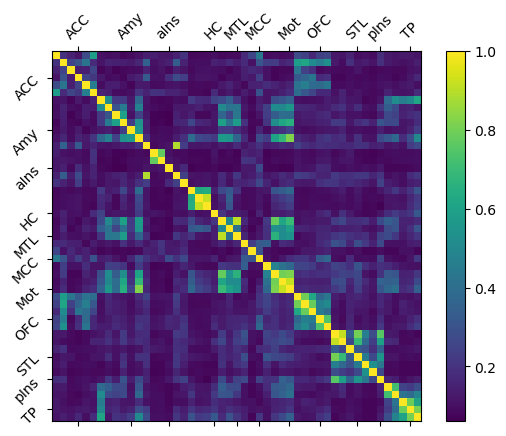

In [95]:
fig, ax = plt.subplots(1)
im = plt.matshow(coherence_data, fignum=0,norm='linear',cmap='viridis')
fig.colorbar(im, ax=ax)
#ax.secondary_xaxis('top',)
#ax.set_xticks(subsets) 


ax.set_xticks(roi_idx)
ax.set_xticklabels(rois,rotation=45)
ax.set_yticks(roi_idx)
ax.set_yticklabels(rois,rotation=45)
#plt.savefig("Ignacio_OFC_Coherence.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [36]:
#OFC only coherence_data
ofc_idx = [ix for ix, ch in enumerate(anode_gm_elecs) if "olf" in ch]


In [47]:
ofc1 = coherence_data[ofc_idx,:]

In [48]:
ofc1.shape

(5, 49)

In [49]:
ofc2 = coherence_data[:,ofc_idx]

In [54]:
ofc1[:,ofc_idx]

array([[1.        , 0.79352088, 0.61671748, 0.35515094, 0.37923844],
       [0.79352088, 1.        , 0.76430639, 0.41813512, 0.4516042 ],
       [0.61671748, 0.76430639, 1.        , 0.39910474, 0.33639805],
       [0.35515094, 0.41813512, 0.39910474, 1.        , 0.6473613 ],
       [0.37923844, 0.4516042 , 0.33639805, 0.6473613 , 1.        ]])

In [52]:
ofc2[ofc_idx,:]

array([[1.        , 0.79352088, 0.61671748, 0.35515094, 0.37923844],
       [0.79352088, 1.        , 0.76430639, 0.41813512, 0.4516042 ],
       [0.61671748, 0.76430639, 1.        , 0.39910474, 0.33639805],
       [0.35515094, 0.41813512, 0.39910474, 1.        , 0.6473613 ],
       [0.37923844, 0.4516042 , 0.33639805, 0.6473613 , 1.        ]])

Text(0.5, 1.0, 'MS017')

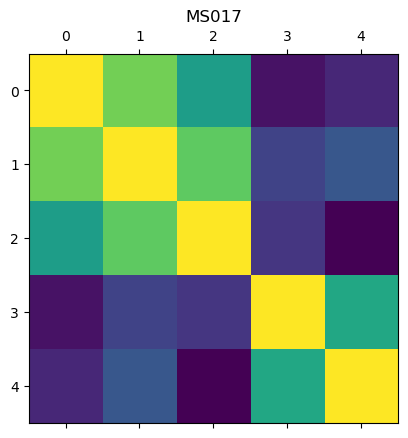

In [57]:
#OFC only plot
fig, ax = plt.subplots(1)
plt.matshow(ofc2[ofc_idx,:], fignum=0,norm='log',cmap='viridis')
plt.title('MS017')


In [319]:
gm_elecs

rois = ['Anterior Cingulate', 'Amygdala','Anterior Insula','Hippocampus','Inferior Insula','Middle Cingulate', 'Middle Insula', 'Orbitofrontal','Posterior Cingulate','Posterior Insula','Temporal Pole']

['lacas10-lalps9',
 'lacas2-lalps4',
 'lacas4-lmolf1',
 'lacas5-lmolf5',
 'lacas6-lalps4',
 'lacas8-lalps7',
 'laglt1-ltplt4',
 'laglt2-lhplt5',
 'laglt5-lhplt5',
 'laglt6-lhplt6',
 'laglt8-lhplt7',
 'laglt9-lhplt7',
 'lalps1-lalps6',
 'lalps11-lalps9',
 'lalps12-lalps9',
 'lalps13-lmcms6',
 'lalps2-lalps6',
 'lalps3-lalps6',
 'lhplt1-lhplt5',
 'lhplt2-lhplt5',
 'lhplt3-lhplt5',
 'lhplt8-lhplt7',
 'lhplt9-lllt5',
 'lllt1-lhplt5',
 'lllt6-lhplt7',
 'lmcms1-lalps8',
 'lmcms3-lalps9',
 'lmcms7-lalps10',
 'lmlbr1-lalps6',
 'lmlbr2-lllt4',
 'lmlbr3-lhplt7',
 'lmlbr4-lhplt7',
 'lmolf2-lalps4',
 'lmolf4-lalps4',
 'lmolf6-lalps4',
 'lmolf7-lalps4',
 'lmolf8-lalps4',
 'lpcwr10-lplsp6',
 'lpcwr11-lplsp6',
 'lpcwr8-lplsp4',
 'lpcwr9-lplsp5',
 'lplsp1-lplsp4',
 'lplsp2-lplsp3',
 'lplsp9-lplsp8',
 'ltplt2-ltplt4',
 'ltplt3-ltplt4',
 'ltplt5-ltplt4',
 'ltplt6-ltplt4',
 'ltplt7-ltplt4']

In [ ]:
#salman code 


#samplerate, band, metric, indices, n_cycles, rois
def compute_connectivity(self, eeg_mne, samplerate, band, metric, indices, n_cycles):
    """
    Compute different connectivity metrics using mne.
    :param eeg_mne: MNE formatted EEG
    :param samplerate: sample rate of the data
    :param band: tuple of band of interest
    :param metric: 'psi' or 'coh', usually.
    :param indices: determine the source and sink for connectivity. Matters most for directional metrics i.e. 'psi'
    :return:
    pairwise connectivity: array of pairwise weights for the connectivity metric with some number of timepoints
    """
    if metric == 'psi':
        pairwise_connectivity = np.squeeze(phase_slope_index(eeg_mne,
                                                                indices=indices,
                                                                sfreq=samplerate,
                                                                mode='cwt_morlet',
                                                                fmin=band[0], fmax=band[1],
                                                                tmin=eeg_mne.tmin + (self.buf_ms / 1000),
                                                                tmax=eeg_mne.tmax - (self.buf_ms / 1000),
                                                                cwt_freqs=self.freqs,
                                                                cwt_n_cycles=n_cycles,
                                                            verbose='warning')[0])
    else:
        pairwise_connectivity = np.squeeze(spectral_connectivity_epochs(eeg_mne,
                                                                    indices=indices,
                                                                    method=metric,
                                                                    sfreq=samplerate,
                                                                    mode='cwt_morlet',
                                                                    fmin=band[0], fmax=band[1], faverage=True,
                                                                    tmin=eeg_mne.tmin + (self.buf_ms / 1000),
                                                                    tmax=eeg_mne.tmax - (self.buf_ms / 1000),
                                                                    cwt_freqs=self.freqs,
                                                                    cwt_n_cycles=n_cycles,
                                                                    verbose='warning')[0])
    return pairwise_connectivity

In [ ]:
seed_target_df = pd.DataFrame(columns=['seed', 'target'], index=['left', 'right'])
seed_target_df['seed']['left'] = np.where(self.elec_info[~right_elec_mask].regions == self.roi[0])[0]
seed_target_df['target']['left'] = np.where(self.elec_info[~right_elec_mask].regions == self.roi[1])[0]
seed_target_df['seed']['right'] = np.where(self.elec_info[right_elec_mask].regions == self.roi[0])[0]
seed_target_df['target']['right'] = np.where(self.elec_info[right_elec_mask].regions == self.roi[1])[0]

seed_target_df = seed_target_df[
    (seed_target_df['seed'].map(lambda d: len(d) > 0)) & (seed_target_df['target'].map(lambda d: len(d) > 0))]

for hemi in ['left', 'right']:
    # first determine if ipsi connectivity is even possible; if not, move on
    if hemi not in seed_target_df.index.tolist():
        continue
    else:
        seed_to_source = seed_target_indices(
            seed_target_df['seed'][hemi],
            seed_target_df['target'][hemi])

psi_nr = self.compute_connectivity(eeg_mne[forgotten_data_mask],
                                                           samplerate=self.mne_samplerate,
                                                           band=[self.fb['low_theta'][0], self.fb['high_theta'][1]],
                                                           metric='psi',
                                                           indices=seed_to_source,
                                                           n_cycles=7)